lab 6 - Однопараметрический метод

вспомогательные функции

In [38]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import sys

def generate_symmetrical_matrix(l, r, n):
    a = np.random.uniform(l, r, (n, n))
    a = np.tril(a) + np.tril(a, -1).T
    return a

# векторная норма
def vec_norm(v):
  s = np.sum(v ** 2)
  return np.sqrt(s)

# генерация вектора
def generate_vec(l, r, n):
  vec = np.random.uniform(l, r, n)
  return vec

def print_matrix(a):
    for i in range(len(a)):
        print(a[i])

In [ ]:
def increase_diag_elems(a, diag):
    n = len(a)
    for i in range(0, len(a)):
        a[i][i] = diag * sum(abs(a[i][j]) if j != i else 0 for j in range(n))
    return a

# Вычисляем диагональное преобладание
# Проверить выполнение условия диагонального преобладания
def calc_diagonal_dominance(a):
  degree = max(abs(a[i][i]) - sum(abs(a[i][j]) if j != i else 0 for j in range(len(a))) for i in range(len(a)))
  return degree > 0

Метод Крылова

In [ ]:
def krylov_algo(matrix):
  p = []
  n = len(matrix)
  AA = deepcopy(matrix)
  y = [[1] * n]
  A = []
  for i in range(1, n + 1):
    y.append(np.dot(AA, y[i - 1]))
  for i in range(n - 1, -1, -1):
    A.append(y[i])
  A = np.transpose(np.array(A))
  f = y[n]

  p_vec = np.linalg.solve(A, f)
  p.append(1)
  for pp in p_vec:
    p.append(-pp)
  return y, p

Вычисление кругов (интервалов Гершгорина)

In [ ]:
def union_intervals(ints):
  union = []
  for start, end in sorted(ints):
    if union and union[-1][1] >= start - 1:
      union[-1][1] = max(union[-1][1], end)
    else:
      union.append([start, end])
  return union

In [ ]:
def find_gershgorin_intervals(matrix):
  A = deepcopy(matrix)
  # центры
  centers = np.diagonal(A)
  n = len(centers)
  # радиусы
  rads = []
  for i in range(n):
    rads.append(np.sum(np.abs(A[i])) - centers[i])
  # print()
  # print(rads)
  intervals = [ (centers[i] - rads[i], centers[i] + rads[i]) for i in range(n)]
  # print(intervals)
  intervals = union_intervals(deepcopy(intervals))
  return intervals

поиск собственных значений

In [ ]:
def polynomy(a, x):
  # a[0]*x**(N-1) + a[1]*x**(N-2) + ... + a[N-2]*x + a[N-1]
  val = 0
  n = len(a)
  for i in range(n-1, -1, -1):
    val += a[n - 1 - i] * x**i
  return val

def find_eigen_values(eqCoeffs, intervals, len):
  # print(intervals)
  values = []
  len2 = 10e-7
  for interval in intervals:
    left = interval[0]
    right = interval[1]
    # print(left, right)
    l = int(np.floor((right - left) / len))
    # print(l)
    for i in range(l):
      x_left = left + i * len
      x_right = x_left + len
      # print(f'left x: {x_left}')
      # print(f'right x: {x_right}')
      y_left = polynomy(eqCoeffs, x_left)
      y_right = polynomy(eqCoeffs, x_right)
      # print(f'left y: {y_left}')
      # print(f'right y: {y_right}')
      alpha = y_left * y_right
      # print(alpha)
      if (alpha < 0):
        while x_right - x_left >= len2:
          x_middle = (x_right + x_left) / 2
          y_middle = polynomy(eqCoeffs, x_middle)
          beta = y_left * y_middle
          if beta < 0:
            x_right = x_middle
          else:
            x_left = x_middle
        values.append((x_right + x_left) / 2)
      elif y_left == 0:
        values.append(x_left)
      elif y_right == 0:
        values.append(x_right)
  return values

Однопараметрический метод простых итераций

In [39]:
def one_param_method(A, f, x_correct, t, eigenvals):
  eps = 1e-4
  n = len(A)
  iters = 0

  # P = E - t A, где t - параметр
  P = (np.eye(n) - t * A)
  g = t * f
  # μ_i = 1 - t * λ_i
  m = []
  for lamb in eigenvals:
    m.append(abs(1 - float(t) * lamb))
  # max|μ_i|
  abs_mu_max = max(m)

  x = g
  # вектор ошибок
  r = x - x_correct
  while True:
    x_i = P @ x + g
    r_i = P @ r
    iters += 1
    print(f'iteration: {iters}')
    if (vec_norm(r_i) ** 2 <= abs_mu_max ** 2 * vec_norm(r) ** 2 + eps):
      print("условие сходимости выполнено")
    if (abs_mu_max < 1):
      print("модуль максимального значения μ_i меньше 1")

    if vec_norm(x - x_i) < eps:
      break

    x = x_i
    r = r_i

  return x, iters

тестирование

In [67]:
n = 5
# матрица должна быть симметричной и положительно определенной
a = generate_symmetrical_matrix(1, 10, n)
a = increase_diag_elems(a, n)
print('matrix a:')
print(a)

f = generate_vec(1, 10, n)
print(f'\nvector f: {f}')

diag_cond = calc_diagonal_dominance(a)
print(f'\ncheck for diagonal dominance condition: {diag_cond}')

# Метод Крылова
intervals = find_gershgorin_intervals(a)
# print(f'\nU intervals: {intervals}')

Ys, P = krylov_algo(a)
# print(f'\nchar equatation coeffs:\n {P}')
# print(f'\nY:')
# for y in Ys:
#   print(y)

# собтвенные значения
vals = find_eigen_values(P, intervals, 10e-3)
print(f'\neigenvalues: {vals}')

# Вычисляем оптимальное t
eigenmin, eigenmax = min(vals), max(vals)
t_optimal = 2 / (eigenmin + eigenmax)
print(f'\nt_opt: {t_optimal}')
# пределы t для графика
t_left = 0.001
t_right = 2 / eigenmax
print(f'\nt ∈ [{t_left} , {t_right}]')

# correct res
x_correct = np.dot(np.linalg.inv(a), f)

# one param method res
x_, iters = one_param_method(a, f, x_correct, t_optimal, vals)


print(f'\ncorrect res: {x_correct}')
print(f'method res: {x_}, iters: {iters}')

matrix a:
[[138.49194451   8.83371401   6.62183057   4.92263885   7.32020546]
 [  8.83371401 106.1653674    2.06797511   4.4656242    5.86576016]
 [  6.62183057   2.06797511  77.46281881   2.87126955   3.93148853]
 [  4.92263885   4.4656242    2.87126955  88.92778555   5.52602451]
 [  7.32020546   5.86576016   3.93148853   5.52602451 113.21739334]]

vector f: [4.08613391 2.86545919 4.46234072 7.45382624 2.66124869]

check for diagonal dominance condition: True

eigenvalues: [76.16868491681419, 87.29938682111109, 102.35223105939232, 113.29598228009544, 145.14902488263448]

t_opt: 0.009036782469023102

t ∈ [0.001 , 0.013778942032970408]
iteration: 1
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 2
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 3
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 4
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 5
усло

Выходные данные были обрезаны до нескольких последних строк (5000).
iteration: 2561
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 2562
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 2563
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 2564
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 2565
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 2566
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 2567
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 2568
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 2569
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 2570
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 2571
условие сходимости выполнено
модуль 


условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 4228
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 4229
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 4230
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 4231
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 4232
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 4233
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 4234
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 4235
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 4236
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 4237
условие сходимости выполнено
модуль максимального значения λ_i меньше 1
iteration: 4238
условие сходимости выполнено
мо

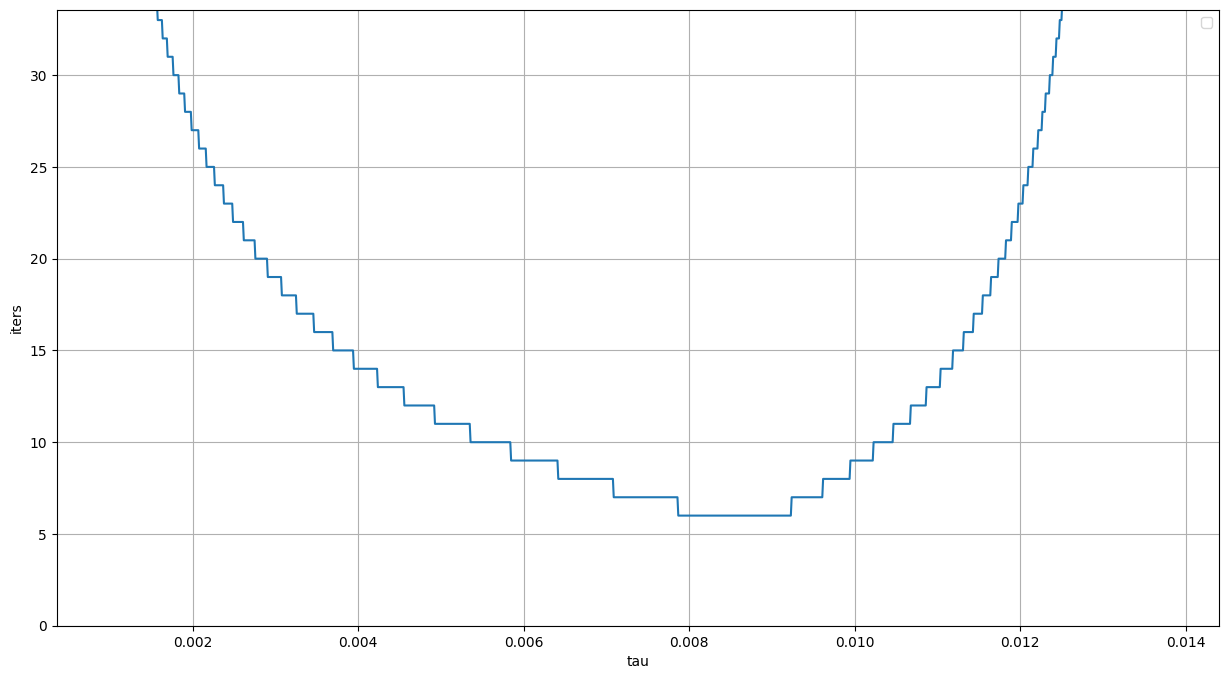


t_opt on graphic: 0.00787000000000002
t_opt: 0.009036782469023102


In [68]:
# График
# iters = []
plt.figure(figsize=(15,8))
plt.xlabel('tau')
plt.ylabel('iters')

taus = np.arange(t_left, t_right, 0.00001)
iters = [one_param_method(a, f, x_correct, tau, vals)[1] for tau in taus]

plt.plot(taus, iters)
plt.ylim(0, np.mean(iters))
# t оптимальное по графику
tau_it = taus[np.argmin(iters)]

plt.legend()
plt.grid()
plt.show()

print(f'\nt_opt on graphic: {tau_it}')
print(f't_opt: {t_optimal}')